In [1]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
class Tree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.n_nodes = 0
        self.root = None
        self.fitness = float('inf')
        
        
    def copy(self):
        tree = Tree(self.max_depth)
        tree.n_nodes = self.n_nodes
        tree.root = self.root.copy()
        tree.fitness = self.fitness
        return tree
    
    
    def calculate_n_nodes(self):
        self.n_nodes = self.calculate_n_nodes_rec(self.root)
    
    
    def calculate_n_nodes_rec(self, node):
        current = 1
        if node.left != None:
            current += self.calculate_n_nodes_rec(node.left)
        if node.right != None:
            current += self.calculate_n_nodes_rec(node.right)
            
        return current
        
        
    def calculate_fitness(self, data, labels, mean_Y):
        if self.n_nodes > 255:
            self.fitness = float('inf')
        else:
            sum_error = 0
            sum_mean = 0
            for i in range(data.shape[0]):
                sum_error += (labels[i]-self.evaluate(data[i]))**2
                sum_mean += (labels[i]-mean_Y)**2

            self.fitness = math.sqrt(sum_error/sum_mean)
        return self.fitness
        
        
    def select_node(self, index):
        node = self.select_rec(index, self.root, 0)
        return (node[1], node[2], node[3])
        
        
    def select_rec(self, index, node, current):
        if index == current:
            return (index, node, None, None)
        else:
            if node.left != None:
                l_index, l_node, l_parent, l_direction = self.select_rec(index, node.left, current+1)
                if l_index == index:
                    if l_parent == None:
                        return (l_index, l_node, node, 'left')
                    else:
                        return (l_index, l_node, l_parent, l_direction)
                current = l_index
            if node.right != None:
                r_index, r_node, r_parent, r_direction = self.select_rec(index, node.right, current+1)
                if r_index == index:
                    if r_parent == None:
                        return (r_index, r_node, node, 'right')
                    else:
                        return (r_index, r_node, r_parent, r_direction)
                current = r_index
            return (current, None, None, None)
    
        
    def evaluate(self, variables):
        return self.evaluate_rec(variables, self.root)
    
    
    def evaluate_rec(self, variables, node):
        if node.node_type == 'terminal':
            if type(node.value) is float:
                return node.value
            else:
                pos = int(node.value[1:])
                return variables[pos]
        else:
            left = self.evaluate_rec(variables, node.left)
            right = self.evaluate_rec(variables, node.right)
            if node.value == '+':
                return left + right
            elif node.value == '-':
                return left - right
            elif node.value == '*':
                return left * right
            else:
                if right != 0:
                    return left / right
                else:
                    return float('inf')
        
        
    def __str__(self):
        return self.print_tree(self.root)
    
    
    def print_tree(self, node):
        string = str(node)
        if node.left != None:
            string += " " + self.print_tree(node.left)
            
        if node.right != None:
            string += " " + self.print_tree(node.right)
            
        return string
        
        
        
class Node:  
    def __init__(self, node_type, nvars, value=None, left=None, right=None):
        self.node_type = node_type
        self.left = left
        self.right = right
        self.value = value
        self.nvars = nvars
        if value == None:
            if node_type == 'function':
                self.value = random.choice(['+', '-', '*', '/'])
            elif node_type == 'terminal':
                choice = random.choice(['x'+str(i) for i in range(nvars)] + ['const'])
                if choice == 'const':
                    self.value = random.random()
                    if random.randint(0,1) == 1:
                        self.value *= -1
                else:
                    self.value = choice
                
                
    def copy(self):
        left = None
        right = None
        if self.left != None:
            left = self.left.copy()
        if self.right != None:
            right = self.right.copy()
        return Node(self.node_type, self.nvars, self.value, left, right)
                
                
    def __str__(self):
        return str(self.value)

In [3]:
class GeneticProgramming:
    def __init__(self, pop_size, ngenerations, max_depth, tournament, pc, pm, elitism, nvars, train_data, train_labels, test_data, test_labels):
        self.pop_size = pop_size
        self.ngenerations = ngenerations
        self.max_depth = max_depth
        self.tournament = tournament
        self.pc = pc
        self.pm = pm
        self.elitism = elitism
        self.nvars = nvars
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.population = None
        
        
    def create_tree(self, max_depth, method):
        tree = Tree(max_depth)
        root = Node('function', self.nvars)
        if method == 'grow':
            n_nodes = self.grow_tree(root, 0, max_depth)
        else:
            n_nodes = self.full_tree(root, 0, max_depth)
        tree.root = root
        tree.n_nodes = n_nodes
        return tree
    
    
    def grow_tree(self, node, current_depth, max_depth):
        nodes = 1
        if node.node_type == 'function':
            if current_depth < max_depth-1:
                node_type = random.choice(['terminal', 'function'])
                left = Node(node_type, self.nvars)
                node.left = left
                nodes += self.grow_tree(left, current_depth+1, max_depth)

                node_type = random.choice(['terminal', 'function'])
                right = Node(node_type, self.nvars)
                node.right = right
                nodes += self.grow_tree(right, current_depth+1, max_depth)
            elif current_depth == max_depth-1:
                node_type = 'terminal'
                left = Node(node_type, self.nvars)
                node.left = left

                node_type = 'terminal'
                right = Node(node_type, self.nvars)
                node.right = right
                nodes += 2
                
        return nodes
                
                
    def full_tree(self, node, current_depth, max_depth):
        nodes = 1
        if node.node_type == 'function':
            if current_depth < max_depth-1:
                node_type = 'function'
                left = Node(node_type, self.nvars)
                node.left = left
                nodes += self.full_tree(left, current_depth+1, max_depth)

                node_type = 'function'
                right = Node(node_type, self.nvars)
                node.right = right
                nodes += self.full_tree(right, current_depth+1, max_depth)
            elif current_depth == max_depth-1:
                node_type = 'terminal'
                left = Node(node_type, self.nvars)
                node.left = left

                node_type = 'terminal'
                right = Node(node_type, self.nvars)
                node.right = right
                nodes += 2
                
        return nodes
        
        
    def create_population(self):
        population = []
        divisions = self.pop_size//14
        n_trees = 0
        for i in range(7):
            for method in ['grow', 'full']:
                for j in range(divisions):
                    population.append(self.create_tree(i+1, method))
                    n_trees += 1
                    
        while n_trees < self.pop_size:
            population.append(self.create_tree(7,'grow'))
            n_trees += 1
        return population
    
    
    def evaluate_population(self, mean_Y):
        for p in self.population:
            p.calculate_fitness(self.train_data, self.train_labels, mean_Y)
    
    
    def crossover(self, parent1, parent2):
        son1 = parent1.copy()
        son2 = parent2.copy()
        selection1 = son1.select_node(random.randint(1, son1.n_nodes-1))
        selection2 = son2.select_node(random.randint(1, son2.n_nodes-1))
        if selection1[2] == 'left':
            selection1[1].left = selection2[0]
        else:
            selection1[1].right = selection2[0]
        son1.calculate_n_nodes()    
        
        return son1
    
    
    def mutate_point(self, individual):
        selection = individual.select_node(random.randint(0, individual.n_nodes-1))[0]
        if selection.node_type == 'function':
            choice = random.choice(['+', '-', '*', '/'])
            while choice == selection.value:
                choice = random.choice(['+', '-', '*', '/'])
            selection.value = choice
        else:
            choice = selection.value
            while choice == selection.value:
                node_class = random.choice(['x'+str(i) for i in range(selection.nvars)] + ['const'])
                if node_class == 'const':
                    choice = random.random()
                    if random.randint(0,1) == 1:
                        choice *= -1
                else:
                    choice = node_class
            selection.value = choice
        return individual
    
            
    def mutate(self, individual):
        selection = individual.select_node(random.randint(1, individual.n_nodes-1))[0]
        node_class = random.choice(['x'+str(i) for i in range(selection.nvars)] + ['const'])
        if node_class == 'const':
            choice = random.random()
            if random.randint(0,1) == 1:
                choice *= -1
        else:
            choice = node_class
        selection.node_type = 'terminal'
        selection.value = choice
        selection.left = None
        selection.right = None
        individual.calculate_n_nodes()   
        return individual
    
    
    def select(self):
        selected = []
        for i in range(self.tournament):
            chosen = random.choice(self.population)
            while chosen in selected:
                chosen = random.choice(self.population)
            selected.append(chosen)
            
        best = selected[0]
        for tree in selected[1:]:
            if tree.fitness < best.fitness:
                best = tree
        
        return best
    
    
    def generate_new_population(self, best_crossover, worst_crossover):
        new_pop = []
        n = 0
        best_counter = 0
        worst_counter = 0
        while n < self.pop_size:
            parent1 = self.select()
            prob = random.random()
            if prob <= self.pc:
                parent2 = self.select()
                new = self.crossover(parent1, parent2)
                parents_mean = (parent1.fitness + parent2.fitness)/2
                if new.fitness < parents_mean:
                    best_counter += 1
                else:
                    worst_counter += 1
                if self.elitism:
                    if new.fitness > parent1.fitness or new.fitness > parent2.fitness:
                        if parent1.fitness < parent2.fitness:
                            new = parent1.copy()
                        else:
                            new = parent2.copy()               
            elif prob <= self.pc + self.pm:
                new = self.mutate(parent1)
            else:
                new = parent1.copy()
            new_pop.append(new)
            n += 1
        best_crossover.append(best_counter)
        worst_crossover.append(worst_counter)
        return new_pop
    
    
    def best_individual(self):
        best = self.population[0]
        for p in self.population[1:]:
            if p.fitness < best.fitness:
                best = p
        return best
    
    
    def generation_statistics(self):
        mean = 0
        inf_number = 0
        worst = float('-inf')
        repeated_fitness = {}
        for p in self.population:
            if p.fitness in repeated_fitness:
                repeated_fitness[p.fitness] += 1
            else:
                repeated_fitness[p.fitness] = 0
            if p.fitness != float('inf'):
                if not math.isnan(p.fitness):
                    mean += p.fitness
                if p.fitness > worst:
                    worst = p.fitness
            else:
                inf_number += 1
        if worst == float('-inf'):
            worst = float('inf')
            
        mean = mean/self.pop_size
        
        number_repeated = 0
        for i in repeated_fitness.values():
            number_repeated += i
        
        return worst, mean, inf_number, number_repeated
    
    
    def evolve(self):
        best_individuals = []
        worst_individuals = []
        inf_individuals = []
        mean_fitness = []
        number_repeated = []
        best_crossover = [0]
        worst_crossover = [0]
        
        mean_Y = np.mean(train_labels)
        self.population = self.create_population()
        self.evaluate_population(mean_Y)
        generation = 1
        print('Generation', generation)
        current_best = self.best_individual()
        print(current_best.fitness)
        best_individuals.append(current_best.fitness)
        current_worst, current_mean, inf_number, repeated = self.generation_statistics()
        worst_individuals.append(current_worst)
        mean_fitness.append(current_mean)
        inf_individuals.append(inf_number)
        number_repeated.append(repeated)
        best = current_best
        while generation < self.ngenerations:
            self.population = self.generate_new_population(best_crossover, worst_crossover)
            self.evaluate_population(mean_Y)
            generation += 1
            print('\nGeneration', generation)
            current_best = self.best_individual()
            print(current_best.fitness)
            best_individuals.append(current_best.fitness)
            current_worst, current_mean, inf_number, repeated = self.generation_statistics()
            worst_individuals.append(current_worst)
            mean_fitness.append(current_mean)
            inf_individuals.append(inf_number)
            number_repeated.append(repeated)
            if current_best.fitness < best.fitness:
                best = current_best
        
        self.plot_statistics(best_individuals, worst_individuals, inf_individuals, 
                             mean_fitness, number_repeated, best_crossover, worst_crossover)
            
        return best
    
    
    def plot_statistics(self, best, worst, inf, mean, repeated, best_crossover, worst_crossover):
        plt.figure()
        f, (ax1) = plt.subplots(1, 1, figsize=(12, 4))
        ax1.set_ylabel('Fitness')
        ax1.set_xlabel('Geração')
        ax1.plot(best, label='melhor fitness')
        ax1.plot(worst, label='pior fitness')
        ax1.plot(mean, label='fitness médio')
        plt.legend(loc='best')
        plt.savefig('graphics/best_worst_mean.png')
        
        plt.figure()
        f, (ax1) = plt.subplots(1, 1, figsize=(12, 4))
        ax1.set_ylabel('Quantidade de indivíduos')
        ax1.set_xlabel('Geração')
        ax1.plot(best_crossover, label='indivíduos melhores')
        ax1.plot(worst_crossover, label='indivíduos piores')
        plt.legend(loc='best')
        plt.savefig('graphics/bestcrossover_worstcrossver.png')
        
        plt.figure()
        f, (ax1) = plt.subplots(1, 1, figsize=(12, 4))
        ax1.set_ylabel('Quantidade de indivíduos')
        ax1.set_xlabel('Geração')
        ax1.plot(inf, label='indivíduos infinitos')
        ax1.plot(repeated, label='indivíduos repetidos')
        plt.legend(loc='best')
        plt.savefig('graphics/inf_repeated.png')
    
    

In [4]:
dataset_name = 'synth1'
#dataset_name = 'synth2'
#dataset_name = 'concrete'

train_dataset = np.loadtxt("datasets/"+dataset_name+"/"+dataset_name+"-train.csv", delimiter=",")

train_labels = train_dataset[:,-1]
train_data = train_dataset[:,:-1]

test_dataset = np.loadtxt("datasets/"+dataset_name+"/"+dataset_name+"-test.csv", delimiter=",")

test_labels = test_dataset[:,-1]
test_data = test_dataset[:,:-1]

nvars = test_data.shape[1]

Generation 1
1.1770354601855149

Generation 2
1.1770354601855149

Generation 3
1.1769991267624207

Generation 4
1.0399825207909477

Generation 5
1.0399825207909477

Generation 6
1.0230233067219714

Generation 7
0.9745148205765242

Generation 8
0.9745148205765242

Generation 9
0.9745148205765242

Generation 10
0.9691367384762243

Generation 11
0.8899262693765315

Generation 12
0.8899262693765315

Generation 13
0.8381136280666615

Generation 14
0.8381136280666615

Generation 15
0.8381136280666615

Generation 16
0.7919638242907587

Generation 17
0.7919638242907587

Generation 18
0.7919638242907587

Generation 19
0.7919449199590635

Generation 20
0.7919449199590635

Generation 21
0.7919449199590635

Generation 22
0.7919449199590635

Generation 23
0.7919449199590635

Generation 24
0.719297542777873

Generation 25
0.719297542777873

Generation 26
0.719297542777873

Generation 27
0.719297542777873

Generation 28
0.7136038723562202

Generation 29
0.7136038723562202

Generation 30
0.70612987801

<Figure size 432x288 with 0 Axes>

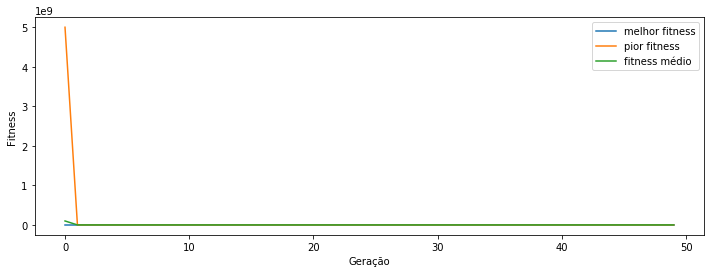

<Figure size 432x288 with 0 Axes>

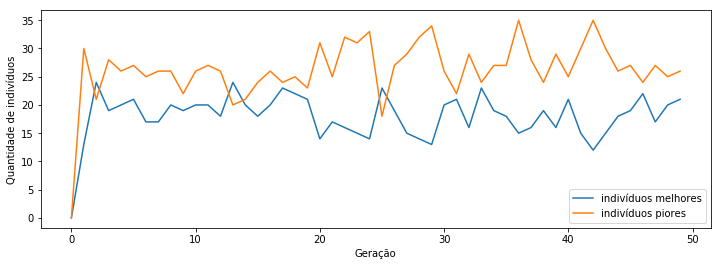

<Figure size 432x288 with 0 Axes>

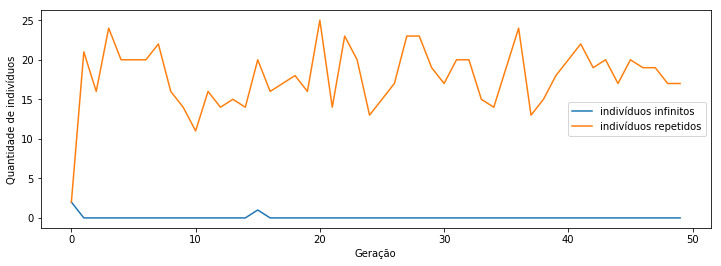

In [5]:
pop_size = 50
ngenerations = 50
max_depth = 7
tournament = 2
pc = 0.9
pm = 0.05
elitism = True

mean_Y = np.mean(train_labels)
GP = GeneticProgramming(pop_size, ngenerations, max_depth, tournament, pc, pm, elitism, nvars, train_data, train_labels, test_data, test_labels)
result = GP.evolve()

print(result)
print('\nTrain fitness', result.fitness)
result.calculate_fitness(test_data, test_labels, np.mean(test_labels))
print('Test fitness', result.fitness)

print('\nTest')
for i in range(test_data.shape[0]):
    print(result.evaluate(test_data[i]), test_labels[i])